In [2]:
### set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import griddata
import scipy.stats as stats
from scipy.optimize import curve_fit

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100)

plt.rcParams.update({'font.size': 16})

In [3]:
def remove_outliers_IQR(data, limit):
    len_nan = len(data[np.isnan(data)])
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    print('Removed %d / %d points' % (np.sum(np.isnan(data_cp))-len_nan, len(data.flatten())))
    return data_cp


# Define a model: a * log10(x) + b
def model(x, a, b):
    return a * np.log10(x) + b

# Bisquare weighting function
def bisquare_weight(residuals, c=1.0):
    # Bisquare weight: 1 - (residuals / c)^2 for residuals < c, else 0
    weights = np.ones_like(residuals)
    mask = np.abs(residuals) <= c
    weights[mask] = (1 - (residuals[mask] / c)**2)**2
    return weights

# Perform the fitting with robust bisquare weighting
def robust_fit(x_data, y_data, model, initial_params, maxiter=1, c=1.0):
    # Initial parameter guess for a and b
    params = initial_params
    
    for _ in range(maxiter):
        # Calculate the model predictions
        y_pred = model(x_data, *params)
        
        # Calculate residuals
        residuals = y_data - y_pred
        
        # Get weights using bisquare weighting
        weights = bisquare_weight(residuals, c)
        
        # Perform weighted least squares fit (using curve_fit)
        popt, _ = curve_fit(model, x_data, y_data, p0=params, sigma=weights, absolute_sigma=True)
        params = popt  # Update parameters

    return params

In [4]:
### load the data
# GNSS
GNSS = np.genfromtxt('./data/GNSS_at_SWOT_times_SSH_only.csv', delimiter=",")
# SWOT (2km and unsmoothed)
SWOT = np.genfromtxt('./data/SWOT_at_buoys_SSH_only.csv', delimiter=",")
SWOT_us = np.genfromtxt('./data/SWOT_unsmoothed_SSH_corrected.csv', delimiter=",")
# load coordinates
coords = np.genfromtxt('./data/buoy_locations_FSP_UTM.csv', delimiter=",")

# convert m to mm
GNSS = GNSS*1000
SWOT = SWOT*1000
SWOT_us = SWOT_us*1000


In [5]:
# calculate double differences

# calculate pairwise diffs
GNSS_diffs = np.ones((36, 96))*np.nan
SWOT_diffs = np.ones((36, 96))*np.nan
SWOT_us_diffs = np.ones((36, 96))*np.nan
distances = np.ones((36))*np.nan

# Generate unique pairs of indices
pairs = [(i, j) for i in range(9) for j in range(i + 1, 9)]

# Calculate pairwise differences for the unique pairs
for idx, (i, j) in enumerate(pairs):
    GNSS_diffs[idx, :] = (GNSS[i, :] - GNSS[j, :])
    SWOT_diffs[idx, :] = (SWOT[i, :] - SWOT[j, :])
    SWOT_us_diffs[idx, :] = (SWOT_us[i, :] - SWOT_us[j, :])
    distances[idx] = np.sqrt((coords[i, 0] - coords[j, 0])**2 + (coords[i, 1] - coords[j, 1])**2)

# convert distances to km
distances = distances/1000

# calculate the pairwise double differences
double_diffs = SWOT_diffs - GNSS_diffs
double_diffs_us = SWOT_us_diffs - GNSS_diffs

# remove cycles with all NaNs
columns_to_keep = ~np.isnan(double_diffs).all(axis=0)
double_diffs = double_diffs[:, columns_to_keep]
columns_to_keep = ~np.isnan(double_diffs_us).all(axis=0)
double_diffs_us = double_diffs_us[:, columns_to_keep]


In [6]:
### remove outliers

double_diffs_clean = []
double_diffs_us_clean = []

for i in range(36):
    tmp_double_diffs_clean = remove_outliers_IQR(double_diffs[i,:], 1.5)
    double_diffs_clean.append(tmp_double_diffs_clean)
    tmp_double_diffs_us_clean = remove_outliers_IQR(double_diffs_us[i,:], 1.5)
    double_diffs_us_clean.append(tmp_double_diffs_us_clean)
    
double_diffs_clean = np.array(double_diffs_clean)
dd_std_clean = np.nanstd(double_diffs_clean, axis=1)/np.sqrt(2)
double_diffs_us_clean = np.array(double_diffs_us_clean)
dd_std_us_clean = np.nanstd(double_diffs_us_clean, axis=1)/np.sqrt(2)


Removed 4 / 87 points
Removed 5 / 81 points
Removed 0 / 87 points
Removed 0 / 81 points
Removed 0 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 5 / 81 points
Removed 1 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 3 / 81 points
Removed 3 / 87 points
Removed 1 / 81 points
Removed 2 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 0 / 81 points
Removed 2 / 87 points
Removed 1 / 81 points
Removed 2 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 1 / 81 points
Removed 1 / 87 points
Removed 0 / 81 points
Removed 2 / 87 points
Removed 3 / 81 points
Removed 5 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 0 / 81 points
Removed 3 / 87 points
Removed 0 / 81 points
Removed 1 / 87 points
Removed 3 / 81 points
Removed 1 / 87 points
Removed 1 / 81 points
Removed 4 / 87 points
Removed 2 / 81 points
Removed 2 / 87 points
Removed 1 / 81 points
Removed 2 / 87 points
Removed 1 

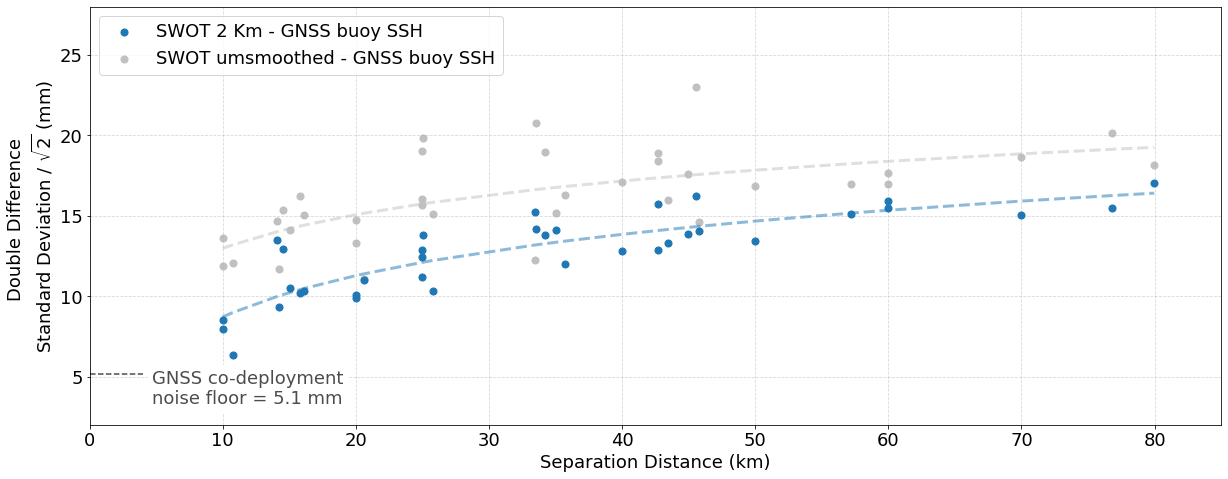

In [7]:
# calculate indicative fit

fig_width = 17.4
plt.rcParams.update({'font.size': 18})

# sort data by distance
sort_idx = np.argsort(distances)
distance_sort = distances[sort_idx]
dd_std_clean_sort = dd_std_clean[sort_idx]
dd_std_us_clean_sort = dd_std_us_clean[sort_idx]
x_data = distance_sort
y_data = dd_std_clean_sort
y_data2 = dd_std_us_clean_sort


# Initial guess for parameters a and b
initial_guess = [1.0, 0.1]

# Fit the model using the robust fitting function
params_fit = robust_fit(x_data, y_data, model, initial_guess)
params_fit2 = robust_fit(x_data, y_data2, model, initial_guess)

# Extract the fitted parameters
a_fit, b_fit = params_fit
a_fit2, b_fit2 = params_fit2

fitted_model = model(x_data, *params_fit)
fitted_model_us = model(x_data, *params_fit2)

# Plotting the data and the fitted curve
fig, ax = plt.subplots(1, figsize=(fig_width,7))
plt.scatter(x_data, y_data, label='SWOT 2 Km - GNSS buoy SSH', color='C0', s=50, zorder=10)
plt.plot(x_data, fitted_model, color='C0', lw=3, alpha=0.5, linestyle='--')
plt.scatter(x_data, y_data2, label='SWOT umsmoothed - GNSS buoy SSH', color='silver', s=50, zorder=1)
plt.plot(x_data, fitted_model_us,   color='silver', lw=3, alpha=0.5, linestyle='--')
plt.xlabel('Separation Distance (km)')
plt.ylabel("Double Difference \nStandard Deviation / $\sqrt{2}$ (mm)")
ax.grid(linestyle='--', alpha=0.5)
ax.set_ylim(2, 28)
ax.set_xlim(0, 85)

ax.plot([0,4], [5.14, 5.14], c='k', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')

props = dict(facecolor='white',  edgecolor='w')
text = "GNSS co-deployment\nnoise floor = 5.1 mm"
ax.text(0.055, 0.05, text, transform=ax.transAxes, bbox=props, alpha=0.7)

plt.tight_layout()
plt.show()

In [8]:
# print mean of the mpoint at lag 10 km
print('For SWOT 2 km product: %.1f mm' % np.nanmean(y_data[0:3]))
print('For SWOT unsmoothed product: %.1f mm' %np.nanmean(y_data2[0:3]))

For SWOT 2 km product: 7.6 mm
For SWOT unsmoothed product: 12.5 mm
